In [1]:
from src.model import generate_ESN
from src.utils import load_data
from src.customs.custom_initializers import WattsStrogatzNX, InputMatrix, ErdosRenyi, RegularNX
from src.model import ESN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import keras
import numpy as np

## Place here the best hyperparameters found by the search

In [2]:
input_scaling = 0.08 # 0.6
degree = 8
spectral_radius = 0.65
rewiring = 1
units = 1800
leak_rate = 1
regularization = 1e-8

## Seed for reproducibility

In [3]:
seed = np.random.randint(0, 1000000)

## Instantiate the initializers

In [4]:
input_init = InputMatrix(sigma=input_scaling, ones=False, seed=seed)

bias_init = keras.initializers.random_uniform(seed=seed)

ws_init = WattsStrogatzNX(
    degree=degree,
    spectral_radius=spectral_radius,
    rewiring_p=rewiring,
    sigma=1,
    ones=True,
    seed=seed,
)

## Load the training data

In [5]:
data_file = (
    "./src/systems/data/Lorenz/Lorenz_dt0.02_steps150000_t-end3000.0_seed264903.csv"
)
train_length = 20000

transient_data, train_data, train_target, ftransient, val_data, val_target = load_data(
    data_file, train_length=train_length, transient=1000
)

features = transient_data.shape[-1]

## Build the model and train

In [6]:

model = generate_ESN(
    units=units,
    features=features,
    input_reservoir_init=input_init,
    reservoir_kernel_init=ws_init,
    input_bias_init=bias_init,
    leak_rate=leak_rate,
    seed=seed,
)

loss = model.train(
    transient_data, train_data, train_target, regularization=regularization
)

Correcting spectral radius to 0.65
Spectral radius was previously 5.624614238739014

Ensuring ESP...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Ensuring ESP took: 0.31 seconds.


Harvesting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Harvesting took: 3.99 seconds.


Calculating readout...
Calculating readout took: 6.17 seconds.

Training loss: 9.155284308448586e-10

NRMSE: 2.186608071497176e-06



## Load different data for evaluation (if needed)

In [7]:
data_file_forecast = (
    "./src/systems/data/Lorenz/Lorenz_dt0.02_steps150000_t-end3000.0_seed923593.csv"
)
train_length = 20000

transient_data, train_data, train_target, ftransient, val_data, val_target = load_data(
    data_file_forecast, train_length=train_length, transient=1000
)

## Make the forecasting

In [8]:
forecast_length = 1000
forecast, states, cumulative_error, threshold_steps = model.forecast(
                                      forecast_length=forecast_length,
                                      forecast_transient_data=ftransient,
                                      val_data=val_data,
                                      val_target=val_target,
                                      error_threshold=0.1)

Output()

## Set the delta t for plotting

In [9]:
dt = 0.02

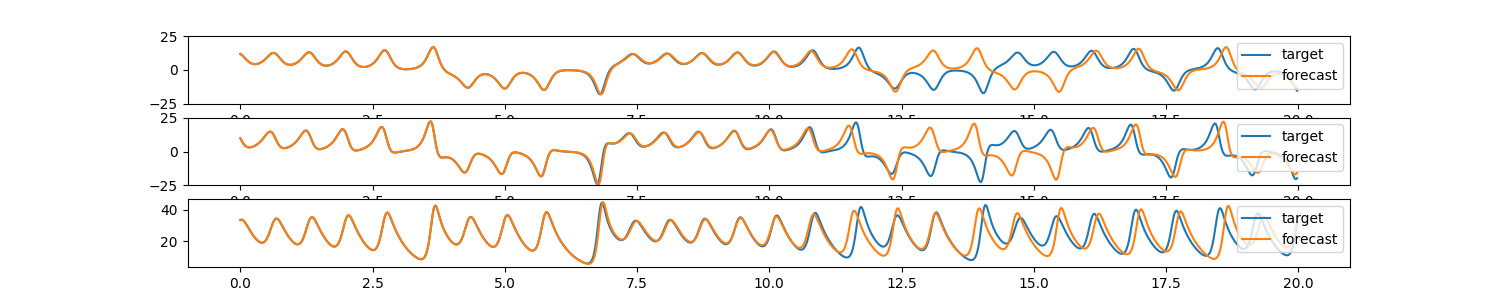

In [10]:
%matplotlib widget
# plot each forecast feature in a subplot, the shape of data is (batch, time, features)
fig, axs = plt.subplots(features, 1, figsize=(15, 3))
for i in range(features):
    axs[i].plot([j*dt for j in range(len(forecast[0, :forecast_length, i]))],val_target[0, :forecast_length, i], label='target')
    axs[i].plot([j*dt for j in range(len(forecast[0, :forecast_length, i]))], forecast[0, :forecast_length, i], label='forecast')
    axs[i].legend()
    # set y range to be from -25 to 25
    if i!=2:
        axs[i].set_ylim(-25, 25)

## Save the model (if needed)

In [ ]:
model.save("your_model_path_and_name")